# Separating Uncertainty
The goal of this notebook is to apply the analysis of [Hawkins and Sutton](https://doi.org/10.1007/s00382-010-0810-6) to the set of candidate climate models in the STITCHES curated archive.

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extract Relevant Data, Global

In [3]:
data_path = '/Users/prim232/gitrepos/stitches_in_r/R/inst/shinyApp/python_curation/extracted_timeseries'
time_series_data_file = 'global_tas_allesms_timeseries_2015_2100.csv'

In [4]:
time_series_data = pd.read_csv(os.path.join(data_path, time_series_data_file), index_col=False)
time_series_data

,year,ann_agg,esm,experiment,ensemble,variable
0,1995,287.436776,CAMS-CSM1-0,historical,r1i1p1f1,tas
1,1996,287.502320,CAMS-CSM1-0,historical,r1i1p1f1,tas
2,1997,287.612017,CAMS-CSM1-0,historical,r1i1p1f1,tas
3,1998,287.661722,CAMS-CSM1-0,historical,r1i1p1f1,tas
4,1999,287.526276,CAMS-CSM1-0,historical,r1i1p1f1,tas
...,...,...,...,...,...,...
58962,2095,290.058673,CanESM5,ssp534-over,r2i1p1f1,tas
58963,2096,290.217145,CanESM5,ssp534-over,r2i1p1f1,tas
58964,2097,290.335867,CanESM5,ssp534-over,r2i1p1f1,tas
58965,2098,290.295876,CanESM5,ssp534-over,r2i1p1f1,tas


In [5]:
# Years in data
years = np.sort(np.unique(time_series_data['year'].values))
n_years = len(years)

In [6]:
# The scenarios we want to be included
scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']

# Ensemble member to use
ensemble_member = 'r1i1p1f1'

In [7]:
# Seeing which models have all scenarios with the given ensemble member
time_series_data[time_series_data['experiment'].isin(scenarios) & 
                # (time_series_data['ensemble'] == ensemble_member) & 
                (time_series_data['year'] == 2015)].groupby('esm')['experiment'].apply(lambda x: len(np.unique(x)))

esm
ACCESS-ESM1-5    4
CAMS-CSM1-0      4
CESM2-WACCM      4
CanESM5          4
FGOALS-g3        4
GFDL-ESM4        4
IPSL-CM6A-LR     4
MIROC6           4
MPI-ESM1-2-HR    4
MPI-ESM1-2-LR    4
MRI-ESM2-0       4
UKESM1-0-LL      4
Name: experiment, dtype: int64

In [8]:
# Seeing which models have all scenarios with the given ensemble member
time_series_data[time_series_data['experiment'].isin(scenarios) & 
                # (time_series_data['ensemble'] == ensemble_member) & 
                (time_series_data['year'] == 2015)]['esm'].value_counts()

MIROC6           153
ACCESS-ESM1-5    115
CanESM5          100
UKESM1-0-LL       54
MPI-ESM1-2-LR     40
IPSL-CM6A-LR      34
MRI-ESM2-0        20
FGOALS-g3         16
MPI-ESM1-2-HR     16
CESM2-WACCM       14
CAMS-CSM1-0        8
GFDL-ESM4          6
Name: esm, dtype: int64

In [9]:
# Arbitrary selection of the 5 models that have all scenarios present
esms = ['CESM2-WACCM', 'GFDL-ESM4', 'MIROC6', 'MRI-ESM2-0', 'IPSL-CM6A-LR']

In [10]:
# Getting only the esms/scenarios (and historical)/ensemble members we want
experiment_data = time_series_data[time_series_data['experiment'].isin(scenarios + ['historical']) & 
                                    (time_series_data['ensemble'] == ensemble_member) & 
                                    (time_series_data['esm'].isin(esms))]
experiment_data

,year,ann_agg,esm,experiment,ensemble,variable
1070,1995,288.585414,MIROC6,historical,r1i1p1f1,tas
1071,1996,288.516346,MIROC6,historical,r1i1p1f1,tas
1072,1997,288.665008,MIROC6,historical,r1i1p1f1,tas
1073,1998,288.697714,MIROC6,historical,r1i1p1f1,tas
1074,1999,289.088271,MIROC6,historical,r1i1p1f1,tas
...,...,...,...,...,...,...
40447,2095,293.053425,CESM2-WACCM,ssp585,r1i1p1f1,tas
40448,2096,293.240190,CESM2-WACCM,ssp585,r1i1p1f1,tas
40449,2097,293.136735,CESM2-WACCM,ssp585,r1i1p1f1,tas
40450,2098,293.167100,CESM2-WACCM,ssp585,r1i1p1f1,tas


# Functions For Fitting Polynomial and Extracting Needed Data

In [11]:
# Get results for a given scenario (slash model)
def get_scenario_results(data, hist_data, ref_tas, experiment, variable, esm):
    # Different value column name for pr and tas
    value_column = 'ann_agg'
    if variable == 'pr':
        value_column = 'pr'

    # Get data specific to this scenario
    experiment_data = data[data['experiment'] == experiment].reset_index(drop=True)

    # Calculate tas anomaly from reference year
    experiment_data['ann_anomaly'] = experiment_data[value_column].copy() - ref_tas

    # print(f'{esm} {experiment} has {len(hist_data.year.values)} historical years and {len(experiment_data.year.values)} future years')

    # Fit data to 4th degree polynomial
    years = np.concatenate([hist_data.year.values, experiment_data.year.values])
    temps = np.concatenate([hist_data.ann_anomaly.values, experiment_data.ann_anomaly.values])
    coeffs = np.polyfit(years, temps, 4)
    # Evaluate with the found coefficients
    smooth_fit = np.polyval(coeffs, years)
    # Extract residuals
    residuals = temps - smooth_fit

    # Return dictionary of results
    return {'time_series': temps, 'fit': smooth_fit, 'residuals': residuals}

In [12]:
# General results for a given ESM
def get_model_results(esm, experiment_data, scenarios, variable):
    # Different value column name for pr and tas
    value_column = 'ann_agg'
    if variable == 'pr':
        value_column = 'pr'

    # Get model data
    data = experiment_data[experiment_data['esm'] == esm].reset_index(drop=True)

    # Get historical data
    hist_data = data[data['experiment'] == 'historical'].reset_index(drop=True)

    # tas at the reference year
    ref_tas = hist_data[hist_data['year'] == 2014][value_column].values[0]

    # Calculating tas anomaly over the historical period
    hist_data['ann_anomaly'] = hist_data[value_column].copy() - ref_tas

    # Get model weight
    model_weight = 1 / (0.25 + np.abs(ref_tas - 0.25))

    # Create model dictionary
    model_dict = {'esm': esm, 'reference_tas': ref_tas, 'weight': model_weight}

    # Get results for each scenario and add it to the model's dictionary
    for exp in scenarios:
        scenario_dict = get_scenario_results(data, hist_data, ref_tas, exp, variable, esm)
        model_dict[exp] = scenario_dict
    
    # Return model results as dictionary
    return model_dict

# Normalized Model Weights

In [13]:
def add_normalized_weights(full_dict):
    weight_sum = 0
    for esm, data in full_dict.items():
        weight_sum += data['weight']

    for esm, data in full_dict.items():
        data['weighted_weight'] = data['weight'] / weight_sum
    
    return full_dict

# Internal Variability
$$V=\sum\limits_{m}W_{m}\text{var}_{s,t}(\varepsilon_{m,s,t})$$

In [14]:
def get_internal_variability(full_dict, scenarios):
    V = 0
    for esm, data in full_dict.items():
        residuals = []
        for exp in scenarios:
            residuals = np.concatenate([residuals, data[exp]['residuals']])

        V += data['weighted_weight'] * np.var(residuals)
    
    return V

# Model Uncertainty
$$M(t)=\frac{1}{N_{s}}\sum\limits_{s}\text{var}_{m}^{W}(x_{m,s,t})$$

In [15]:
def weighted_variance(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return variance

In [16]:
def get_model_uncertainty(full_dict, n_years, esms, scenarios):
    scenario_inner_vars = np.zeros((len(scenarios), n_years))
    j = 0
    for exp in scenarios:
        model_fits = np.zeros((len(esms), n_years))
        model_weights = np.zeros(len(esms))
        i = 0
        for esm, data in full_dict.items():
            model_fits[i, :] = data[exp]['fit']
            model_weights[i] = data['weighted_weight']
            i += 1
        scenario_inner_vars[j,:] = [weighted_variance(model_fits[:,t], model_weights) for t in range(n_years)]
        j += 1

    M = np.array([np.sum(scenario_inner_vars[:,t])/len(scenarios) for t in range(n_years)])
    return M

# Scenario Uncertainty
$$S(t)=\text{var}_{s}(\sum\limits_{m}W_{m}x_{m,s,t})$$

In [17]:
def get_scenario_uncertainty(full_dict, n_years, scenarios):
    scenario_inner_sums = np.zeros((len(scenarios), n_years))
    iteration = 0
    for exp in scenarios:
        inner_sum = [0] * n_years
        for esm, data in full_dict.items():
            inner_sum += data['weighted_weight'] * data[exp]['fit']
        scenario_inner_sums[iteration, :] = inner_sum
        iteration += 1
    S = np.array([np.var(scenario_inner_sums[:,t]) for t in range(n_years)])
    return S

# Plotting

In [18]:
full_dict = {}
for esm in esms:
    full_dict[esm] = get_model_results(esm, experiment_data, scenarios, 'tas')
full_dict = add_normalized_weights(full_dict).copy()
V = get_internal_variability(full_dict, scenarios)
M = get_model_uncertainty(full_dict, n_years, esms, scenarios)
S = get_scenario_uncertainty(full_dict, n_years, scenarios)

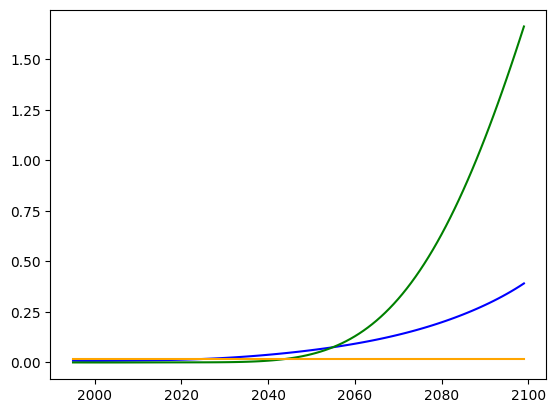

In [19]:
plt.plot(years, M, color='blue')
plt.plot(years, S, color='green')
plt.plot(years, np.repeat(V, n_years), color='orange')

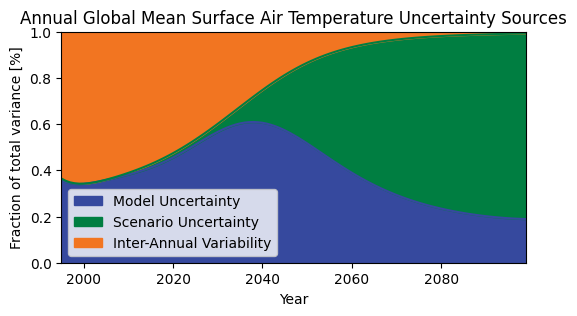

In [20]:
total = M + S + V
df = pd.DataFrame({'year': years, 'Model Uncertainty': M / total, 'Scenario Uncertainty': S / total, 'Inter-Annual Variability': np.repeat(V, n_years) / total})
fig, ax = plt.subplots(1, 1, figsize=(6,3)) 
df.set_index('year').plot.area(ax=ax, 
**{
    'title': 'Annual Global Mean Surface Air Temperature Uncertainty Sources', 
    'xlabel': 'Year', 
    'ylabel': 'Fraction of total variance [%]',
    'color': ['#36499e', '#007e41', '#f27521']
})
ax.set_ylim(ymin=0, ymax=1)
ax.set_xlim(xmin=years[0], xmax=years[-1])
plt.show()

# Getting Models That Have All Scenarios

In [21]:
def get_esms_and_memebers_with_scenarios(directory, filename, scenarios):
    data = pd.read_csv(os.path.join(directory, filename))
    my_obj = data[(data['year'] == 2050) & 
        (data['acronym'] == 'NWN') &
        (data['experiment'].isin(scenarios))].groupby('ensemble')['experiment'].apply(lambda x: len(np.unique(x)))
    members = my_obj.keys()
    number_of_my_scenarios = my_obj.values
    indeces = np.where(number_of_my_scenarios == 4)[0]
    member = None
    if len(indeces) > 0:
        index = indeces[0]
        member = members[index]
    
    return data['esm'].values[0], member, data['variable'].values[0]

In [22]:
directory = os.path.join(data_path, 'land_regions_ts')
esm_arr = [None] * len(os.listdir(directory))
member_arr = [None] * len(os.listdir(directory))
variable_arr = [None] * len(os.listdir(directory))
for i, filename in enumerate(os.listdir(directory)):
    try:
        esm, member, variable = get_esms_and_memebers_with_scenarios(directory, filename, scenarios)
        esm_arr[i] = esm
        member_arr[i] = member
        variable_arr[i] = variable
    except: 
        pass

/var/folders/03/82f8dprj20zdn3zkgcd_p1280000gn/T/ipykernel_2589/1786438731.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  my_obj = data[(data['year'] == 2050) &
/var/folders/03/82f8dprj20zdn3zkgcd_p1280000gn/T/ipykernel_2589/1786438731.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  my_

In [23]:
full_collection = pd.DataFrame({'esm': esm_arr, 'ensemble': member_arr, 'variable': variable_arr})
full_collection = full_collection.dropna()

In [24]:
esms = np.unique(full_collection[full_collection['esm'] != 'NorESM2-LM'].esm.values)
# Note that NorESM2-LM only has all scenarios for tas not pr. See via below command
# full_collection.dropna().groupby('esm')['variable'].apply(lambda x: len(np.unique(x)))
esms

array(['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CAMS-CSM1-0',
       'CESM2', 'CESM2-WACCM', 'CMCC-CM2-SR5', 'CMCC-ESM2', 'CanESM5',
       'EC-Earth3-Veg-LR', 'FGOALS-f3-L', 'FGOALS-g3', 'GFDL-ESM4',
       'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 'MIROC6',
       'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorESM2-MM',
       'UKESM1-0-LL'], dtype=object)

# Separating Uncertainty, IPCC Regions

In [25]:
# TODO: Decide what the behavior should be if you choose model/scenario/ensemble combo that doesn't exist

# Choose ESMs
# From Projection Min
esms2 = ['ACCESS-ESM1-5', 'GFDL-ESM4', 'CAMS-CSM1-0', 'CMCC-CM2-SR5', 'MRI-ESM2-0']
# From Coefficient Min
esms3 = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'MIROC6', 'MRI-ESM2-0']

# Choose Scenarios
scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']

# Choose Ensemble Member
ensemble_member = 'r1i1p1f1'

# Choose variable
variable = 'pr'

# Choose IPCC Region (Acronym)
ipcc_region = 'NEN'

In [26]:
def read_and_filter(directory, file, scenarios, ensemble_member, ipcc_region):
    data = pd.read_csv(os.path.join(directory, file), index_col=False)
    esm = data['esm'].values[0]
    variable = data['variable'].values[0]
    ensemble_member = full_collection[(full_collection['esm'] == esm) & (full_collection['variable'] == variable)]['ensemble'].values[0]

    data = data[(data['ensemble'] == ensemble_member) & 
        (data['experiment'].isin(scenarios + ['historical'])) &
        (data['acronym'] == ipcc_region)].copy()
    return data

In [27]:
def get_results_and_plot(esms, scenarios, ensemble_member, variable, ipcc_region, fig = None, ax = None, title = True):
    # Input files
    input_directory = 'extracted_timeseries/land_regions_ts'
    input_files = [f'IPCC_land_regions_{variable}_{esm}_timeseries_1980-2099.csv' for esm in esms]

    # Read in data
    full_data = pd.concat([read_and_filter(input_directory, file, scenarios, ensemble_member, ipcc_region) for file in input_files]).copy()

    # Years in data
    years = np.sort(np.unique(full_data['year'].values))
    n_years = len(years)

    # Get model fits, and weights
    full_dict = {}
    for esm in esms:
        full_dict[esm] = get_model_results(esm, full_data, scenarios, variable)

    # Get variation results
    full_dict = add_normalized_weights(full_dict).copy()
    V = get_internal_variability(full_dict, scenarios)
    M = get_model_uncertainty(full_dict, n_years, esms, scenarios)
    S = get_scenario_uncertainty(full_dict, n_years, scenarios)

    # Plot
    total = M + S + V
    region_name = full_data['name'].values[0]
    df = pd.DataFrame({'year': years, 'Model Uncertainty': M / total, 'Scenario Uncertainty': S / total, 'Inter-Annual Variability': np.repeat(V, n_years) / total})
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6,3)) 
    if title:
        df.set_index('year').plot.area(ax=ax, 
        **{
            'title': f'Annual {region_name} Mean {variable} Variation Sources', 
            'xlabel': 'Year', 
            'ylabel': 'Fraction of total variance [%]',
            'color': ['#36499e', '#007e41', '#f27521']
        })
    else:
        df.set_index('year').plot.area(ax=ax, 
        **{
            'xlabel': 'Year', 
            'ylabel': 'Fraction of total variance [%]',
            'color': ['#36499e', '#007e41', '#f27521']
        })
    ax.set_ylim(ymin=0, ymax=1)
    ax.set_xlim(xmin=years[0], xmax=years[-1])
    # plt.show()

    return V, M, S, fig, ax, full_data, full_dict

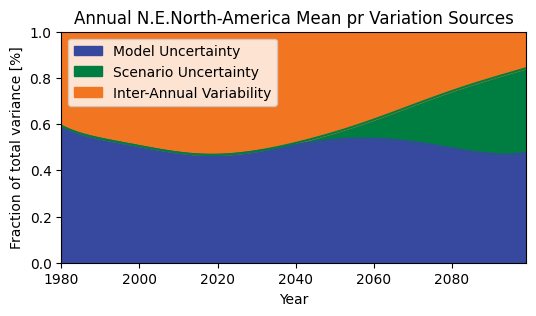

In [28]:
V, M, S, fig, ax, full_data, full_dict = get_results_and_plot(esms, scenarios, ensemble_member, variable, ipcc_region)

In [29]:
access_esm_data = pd.read_csv(os.path.join(data_path, 'land_regions_ts', 'IPCC_land_regions_pr_ACCESS-ESM1-5_timeseries_1980-2099.csv'))
ipcc_land_regions = np.unique(access_esm_data['name'].values)
ipcc_land_regions = np.unique(access_esm_data['acronym'].values)
access_esm_scenarios = np.unique(access_esm_data['experiment'].values)
len(ipcc_land_regions)

43

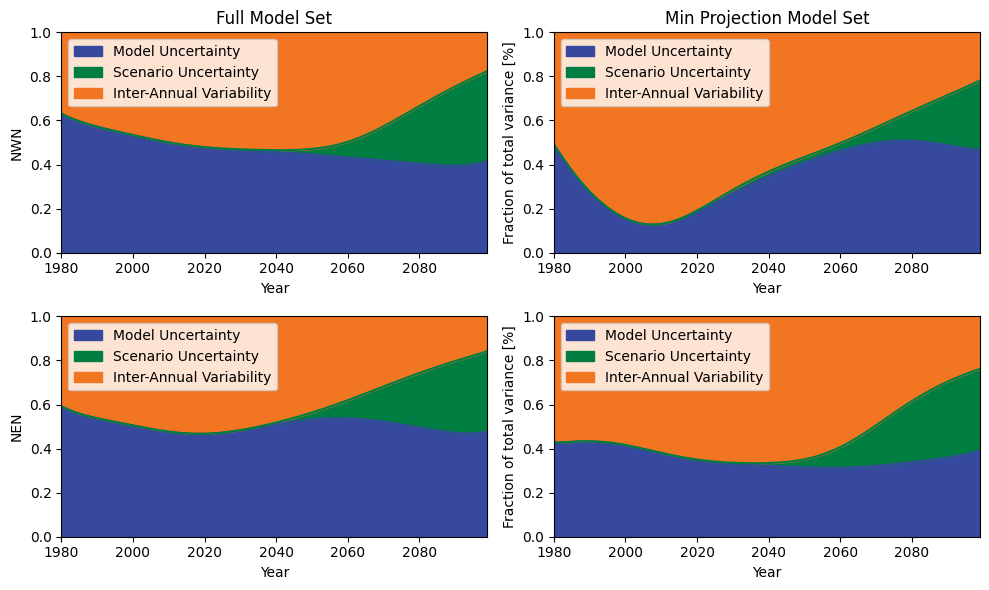

In [30]:
# Smaller Test Plot
fig, axs = plt.subplots(2,2, figsize=(10,6))
V, M, S, _, _, _, _ = get_results_and_plot(esms, scenarios, ensemble_member, variable, 'NWN', ax = axs[0, 0], title=False)
V, M, S, _, _, _, _ = get_results_and_plot(esms2, scenarios, ensemble_member, variable, 'NWN', ax = axs[0, 1], title=False)
V, M, S, _, _, _, _ = get_results_and_plot(esms, scenarios, ensemble_member, variable, 'NEN', ax = axs[1, 0], title=False)
V, M, S, _, _, _, _ = get_results_and_plot(esms2, scenarios, ensemble_member, variable, 'NEN', ax = axs[1, 1], title=False)
axs[0,0].set_title('Full Model Set')
axs[0,1].set_title('Min Projection Model Set')
axs[0,0].set_ylabel('NWN')
axs[1,0].set_ylabel('NEN')
axs[1,0].legend(loc = 'upper left')
fig.tight_layout()
plt.show()

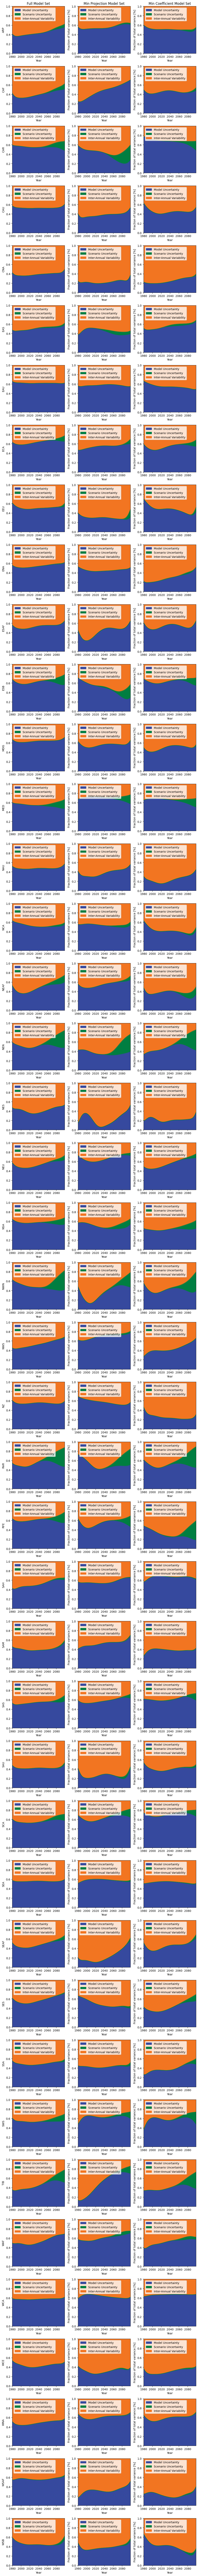

In [31]:
fig, axs = plt.subplots(43, 3, figsize=(10,3*43))

for iter, ipcc_region in enumerate(ipcc_land_regions):
    V, M, S, _, _, _, _ = get_results_and_plot(esms, scenarios, ensemble_member, variable, ipcc_region, ax = axs[iter, 0], title = False)
    V, M, S, _, _, _, _ = get_results_and_plot(esms2, scenarios, ensemble_member, variable, ipcc_region, ax = axs[iter, 1], title = False)
    V, M, S, _, _, _, _ = get_results_and_plot(esms3, scenarios, ensemble_member, variable, ipcc_region, ax = axs[iter, 2], title = False)

    axs[iter,0].set_ylabel(ipcc_region)
    axs[iter,0].legend(loc = 'upper left')
    axs[iter,1].legend(loc = 'upper left')
    axs[iter,2].legend(loc = 'upper left')

axs[0,0].set_title('Full Model Set')
axs[0,1].set_title('Min Projection Model Set')
axs[0,2].set_title('Min Coefficient Model Set')
fig.tight_layout()
plt.show()